In [25]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset

## Fine-tuning MAML vs LSTM

In [55]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "BATTERY"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
lower_trial = 0
upper_trial = 3
learning_rate = 0.001
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [47]:
len(train_data_ML.file_idx)

7592

In [65]:
trial = 0
learning_rate = 0.0001
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file

model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
model2 = nn.Linear(120, 1)

model.cuda()
model2.cuda()

maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))

loss_hist_test =[]
for i in range(1,20):
    loss = test_maml(maml, model, model_name, dataset_name, test_data_ML, 10, learning_rate,0, noise_type, horizon =i)
    print(loss.cpu().numpy())
    loss_hist_test.append(float(loss.cpu().numpy()))
    
    
loss_hist_validation =[]
for i in range(1,20):
    loss = test_maml(maml, model, model_name, dataset_name, validation_data_ML, 10, learning_rate,0, noise_type, horizon =i)
    print(loss.cpu().numpy())
    loss_hist_validation.append(float(loss.cpu().numpy()))
    
loss_hist_train =[]
for i in range(1,20):
    loss = test_maml(maml, model, model_name, dataset_name, train_data_ML, 10, learning_rate,0, noise_type, horizon =i)
    print(loss.cpu().numpy())
    loss_hist_train.append(float(loss.cpu().numpy()))

std: tensor(1.7511e-05, device='cuda:0')
0.0014293013
std: tensor(7.8850e-06, device='cuda:0')
0.001143125
std: tensor(8.2360e-06, device='cuda:0')
0.0012047491
std: tensor(6.1609e-06, device='cuda:0')
0.0010751766
std: tensor(7.0510e-06, device='cuda:0')
0.0011346047
std: tensor(1.9191e-06, device='cuda:0')
0.0008632424
std: tensor(2.1980e-06, device='cuda:0')
0.0009218897
std: tensor(2.6675e-06, device='cuda:0')
0.0009887385
std: tensor(3.3206e-06, device='cuda:0')
0.0010645682
std: tensor(2.5012e-06, device='cuda:0')
0.000970134
std: tensor(2.9250e-06, device='cuda:0')
0.0010313981
std: tensor(2.8191e-06, device='cuda:0')
0.001020908
std: tensor(2.5278e-06, device='cuda:0')
0.0010021036
std: tensor(3.0848e-06, device='cuda:0')
0.0010767387
std: tensor(2.7773e-06, device='cuda:0')
0.0010238051
std: tensor(2.4230e-06, device='cuda:0')
0.0009947165
std: tensor(2.3117e-06, device='cuda:0')
0.0009777443
std: tensor(2.6593e-06, device='cuda:0')
0.0010211776
std: tensor(2.9252e-06, device=

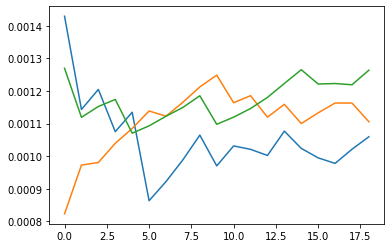

In [66]:
import matplotlib.pyplot as plt
plt.plot(loss_hist_test)
plt.plot(loss_hist_validation)
plt.plot(loss_hist_train)

#pd.DataFrame({"Train": loss_hist_train,
#              "Test": loss_hist_test,
#              "Validation": loss_hist_validation}).to_csv("../../Results/loss_list_iter_horizon_1_BATTERY3.csv")
#

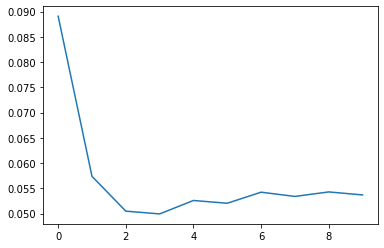

In [41]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)

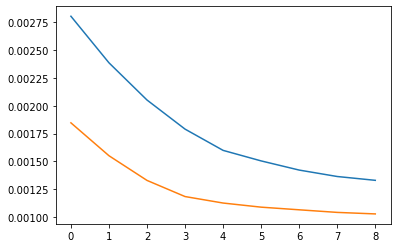

In [55]:
plt.plot(loss_hist)
plt.plot(loss_hist_1)

In [34]:
import pandas as pd
pd.DataFrame(loss_hist).to_csv("../../Results/loss_list_iter_horizon_1_HR2.csv")

In [19]:
trial = 2
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file

model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
model2 = nn.Linear(120, 1)

model.cuda()
model2.cuda()

maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))

for i in range(10):
    loss = test_maml(maml, model, model_name, dataset_name, test_data_ML, i, learning_rate,0, noise_type)
    print(loss.cpu().numpy())

0.04197604
0.041967083
0.041958276
0.041949566
0.04194093
0.041932367
0.04192387


KeyboardInterrupt: 

In [60]:
trial = 2
output_directory_nomaml = "../../Models/"+dataset_name+"_"+model_name+"/"+str(trial)+"/"
save_model_file_nomaml = output_directory_nomaml + "temp_model.pt"
load_model_file_nomaml = output_directory_nomaml + "model.pt"

In [64]:
n_tasks, task_size, dim, channels = test_data_ML.x.shape if is_test else validation_data_ML.x.shape
horizon = 10
freeze_model_flag = True
test_loss_list1 = []
test_loss_list2 = []
initial_test_loss_list1 = []
initial_test_loss_list2 = []
regularization_penalty = 0.0
learning_rate = 0.001
is_test = 1
def test_nomaml(epochs, horizon):

    test_loss_list1 = []

    verbose = 0
    if task_size == 50:
        step = n_tasks//100
    else:
        step = 1

    for task_id in range(0, (n_tasks-horizon-1), step):


        #check that all files blong to the same domain
        temp_file_idx = test_data_ML.file_idx[task_id:task_id+horizon+1] if is_test else validation_data_ML.file_idx[task_id:task_id+horizon+1]
        if(len(np.unique(temp_file_idx))>1):
            continue

        if is_test: 
            temp_x_train = test_data_ML.x[task_id]
            temp_y_train = test_data_ML.y[task_id]

            temp_x_test1 = test_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test1 = test_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)

            temp_x_test2 = test_data_ML.x[(task_id+1)].reshape(-1, dim, channels)
            temp_y_test2 = test_data_ML.y[(task_id+1)].reshape(-1, 1)

        else:
            temp_x_train = validation_data_ML.x[task_id]
            temp_y_train = validation_data_ML.y[task_id]

            temp_x_test1 = validation_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test1 = validation_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)

            temp_x_test2 = validation_data_ML.x[(task_id+1)].reshape(-1, dim, channels)
            temp_y_test2 = validation_data_ML.y[(task_id+1)].reshape(-1, 1)


        if model_name == "FCN":

            kernels = [8,5,3] if dataset_name!= "POLLUTION" else [4,2,1]
            temp_x_train = np.transpose(temp_x_train, [0,2,1])
            temp_x_test1 = np.transpose(temp_x_test1, [0,2,1])
            temp_x_test2 = np.transpose(temp_x_test2, [0,2,1])
            #temp_x_val = np.transpose(temp_x_val, [0,2,1])

        early_stopping = EarlyStopping(patience=patience_stopping, model_file=save_model_file_nomaml, verbose=verbose)


        if model_name == "LSTM":
            model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
        elif model_name == "FCN":
            model = FCN(time_steps = window_size, channels=[input_dim, 128, 128, 128], kernels=kernels )


        model.load_state_dict(torch.load(load_model_file_nomaml))

        train_loader = DataLoader(SimpleDataset(x=temp_x_train, y=temp_y_train), **params)
        test_loader1 = DataLoader(SimpleDataset(x=temp_x_test1, y=temp_y_test1), **params)
        test_loader2 = DataLoader(SimpleDataset(x=temp_x_test2, y=temp_y_test2), **params)

        verbose = False

        model.cuda()
        #initial_loss1 = test(model, test_loader1, output_directory, load_model_file_nomaml, verbose)
        #initial_loss2 = test(model, test_loader2, output_directory, load_model_file_nomaml, verbose)

        if freeze_model_flag:
            freeze_model(model)

        #early_stopping(initial_loss, model)
        train(model, train_loader, test_loader1, early_stopping, learning_rate, epochs, regularization_penalty) 
        early_stopping(0.0, model)
        loss1 = test(model, test_loader1, output_directory, save_model_file_nomaml, verbose, threshold=True)
        #loss2 = test(model, test_loader2, output_directory, save_model_file_nomaml, verbose)
        #print(loss1)

        test_loss_list1.append(loss1)
        #initial_test_loss_list1.append(initial_loss1)
        #test_loss_list2.append(loss2)
        #initial_test_loss_list2.append(initial_loss2)

    return test_loss_list1#, initial_test_loss_list1 #initial_test_loss_list2

In [65]:
a, b = test_nomaml(epochs = 1,horizon = 1)

KeyboardInterrupt: 

In [ ]:
np.mean(b)

In [66]:
loss_hist_2 = []
loss_hist_1 = []

for i in range(1,30):
    
    a = test_nomaml(epochs = 1,horizon = i)
    loss_hist_1.append(np.mean(a))
    #loss_hist_2.append(np.mean(b))
    print(i)
    print(loss_hist_1[-1])

1
0.001806072812149639
2
0.0015078166599414545
3
0.0015523086277244146
4
0.0014064609308754408
5
0.0014800881029686378
6
0.0012008423436782323
7
0.0012455583752550108
8
0.001292105744444901
9
0.0013390659284292876
10
0.0012608377601668992
11
0.001332059801225501
12
0.0013009250994586456
13
0.001240814114799318
14
0.0013276352422152463
15
0.0012122078533543068
16
0.0012228819894803207
17
0.0011818799420408059
18
0.0012156390297274231
19
0.0012277755666383944
20
0.001225514940906787
21
0.0012457935884193484
22
0.0012940212180329509
23
0.0012099292763132537
24
0.001287235589230942
25
0.0013089867702493554
26
0.0013685618746205278
27
0.0012986276944656015
28
0.001369022901895097
29
0.0013995217706402202


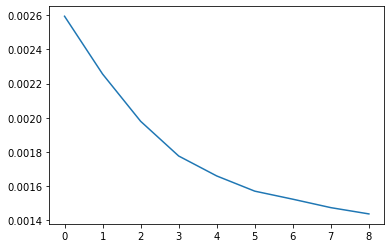

In [44]:
plt.plot(loss_hist_1)

In [68]:
import pandas as pd
pd.DataFrame(loss_hist_1).to_csv("../../Results/nomaml_loss_list_horitzon_iter_1_battery.csv")

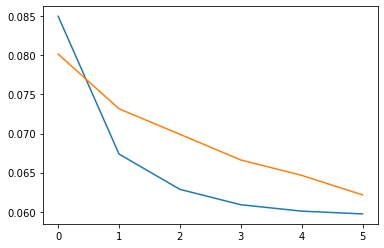

In [11]:
plt.plot([0.08500496479365323,
 0.06737132901137403,
 0.06285849310416446,
 0.06089185114061228,
 0.06007222816436258,
 0.059716195157797844])
plt.plot(loss_hist)

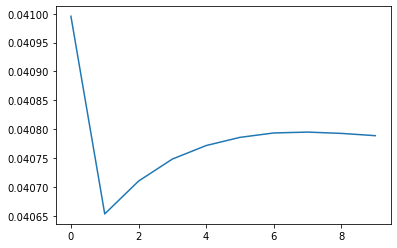

In [65]:
plt.plot([np.mean(c)]+loss_hist_1)
#plt.plot(loss_hist)

In [46]:
[np.mean(d)]+loss_hist_2

[0.04049041833259516,
 0.04032006545457989,
 0.04017948917925776,
 0.04005817117780878,
 0.039963478992255975,
 0.039891795645353896]

In [47]:
[np.mean(c)]+loss_hist_1

[0.040746448149877615,
 0.040759505361926796,
 0.040732728911335676,
 0.04072607707130869,
 0.04073969797915494,
 0.040768694153948855]

In [28]:
loss_hist

[0.07188001275062561,
 0.07164141535758972,
 0.07282017171382904,
 0.07462943345308304,
 0.07598571479320526,
 0.07770521193742752]

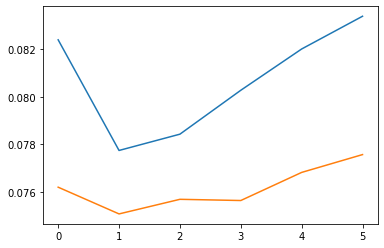

In [13]:
plt.plot([0.08240097133183201,
 0.07774591992872988,
 0.0784311567704323,
 0.08027829599520091,
 0.08201548649288987,
 0.08339315124056083])
plt.plot(loss_hist)

In [40]:
[0.04080845043063164,
 0.04059995338320732,
 0.04090947285294533,
 0.0414884127676487,
 0.04212145879864693,
 0.04266317933797836]

[0.04080845043063164,
 0.04059995338320732,
 0.04090947285294533,
 0.0414884127676487,
 0.04212145879864693,
 0.04266317933797836]

In [48]:
loss_hist

[0.04080845043063164,
 0.04059995338320732,
 0.04090947285294533,
 0.0414884127676487,
 0.04212145879864693,
 0.04266317933797836]

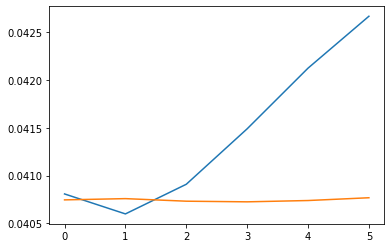

In [49]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)
plt.plot([np.mean(c)]+loss_hist_1)